In [2]:
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 476.9 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 434.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 378.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 517.6 kB/s eta 0:00:00a 0:00:01
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=9c5fc05b1e63f095b743d8acaa0a97135dd5c04ca18da6acad24adc64bd2a9ea
  Stored in directory: /Users/michaela/Library/Caches/pip/wheels/9f/af/22/bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle


In [7]:
!pip install pandas numpy scikit-learn pyradiomics matplotlib nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 366.2 kB/s eta 0:00:0000:0100:03
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 358.1 kB/s eta 0:00:0000:0100:03
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 633.1 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.2/30.2 MB 695.9 kB/s eta 0:00:0000:0100:02
   ━━

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
... resuming from 2648702976 bytes (1819867965 bytes left) ...
100%|█████████████████████████████████████▉| 4.16G/4.16G [02:44<00:00, 10.0MB/s]
100%|██████████████████████████████████████| 4.16G/4.16G [02:45<00:00, 11.0MB/s]


In [5]:
!kaggle datasets download -d washingtongold/lidcidri30

Dataset URL: https://www.kaggle.com/datasets/washingtongold/lidcidri30
License(s): unknown
... resuming from 10669260800 bytes (30539476344 bytes left) ...
100%|████████████████████████████████████| 38.4G/38.4G [1:07:38<00:00, 5.33MB/s]
100%|████████████████████████████████████| 38.4G/38.4G [1:07:38<00:00, 7.52MB/s]


In [31]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk
from radiomics import featureextractor


In [2]:
brats_dir = "./BraTS2020" 

Iterate over the downloaded folder to get an idea of the data structure.

In [ ]:
# Function to list files in a directory
def explore_directory(path):
    for root, dirs, files in os.walk(path):
        print(f"Directory: {root}")
        for file in files:
            print(f"  {file}")

# Explore datasets
print("Exploring BRATS Dataset:")
explore_directory(brats_dir)


Exploring BRATS Dataset:
Directory: ./BraTS2020
  .DS_Store
Directory: ./BraTS2020/BraTS2020_ValidationData
Directory: ./BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData
  survival_evaluation.csv
  name_mapping_validation_data.csv
Directory: ./BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_069
  BraTS20_Validation_069_flair.nii
  BraTS20_Validation_069_t1.nii
  BraTS20_Validation_069_t2.nii
  BraTS20_Validation_069_t1ce.nii
Directory: ./BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_056
  BraTS20_Validation_056_flair.nii
  BraTS20_Validation_056_t2.nii
  BraTS20_Validation_056_t1.nii
  BraTS20_Validation_056_t1ce.nii
Directory: ./BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_051
  BraTS20_Validation_051_flair.nii
  BraTS20_Validation_051_t2.nii
  BraTS20_Validation_051_t1.nii
  BraTS20_Validation_051_t1ce.nii
Directory: ./BraTS2020/BraTS2020_Validation

In [23]:
path_train = os.path.join(brats_dir, "BraTS2020_TrainingData", "MICCAI_BraTS2020_TrainingData")
path_val = os.path.join(brats_dir, "BraTS2020_ValidationData", "MICCAI_BraTS2020_ValidationData")

print(path_train)
print(path_val)

./BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
./BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData


In [25]:
# Print name mapping, including the labels (Grade column)
map_train = pd.read_csv(os.path.join(path_train, "name_mapping.csv"))
map_val = pd.read_csv(os.path.join(path_val, "name_mapping_validation_data.csv"))
map_train.head()

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [26]:
map_val.head()

,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,Brats17_CBICA_AAM_1,Brats18_CBICA_AAM_1,NaN,BraTS19_CBICA_AAM_1,BraTS20_Validation_001
1,Brats17_CBICA_ABT_1,Brats18_CBICA_ABT_1,NaN,BraTS19_CBICA_ABT_1,BraTS20_Validation_002
2,Brats17_CBICA_ALA_1,Brats18_CBICA_ALA_1,NaN,BraTS19_CBICA_ALA_1,BraTS20_Validation_003
3,Brats17_CBICA_ALT_1,Brats18_CBICA_ALT_1,NaN,BraTS19_CBICA_ALT_1,BraTS20_Validation_004
4,Brats17_CBICA_ALV_1,Brats18_CBICA_ALV_1,NaN,BraTS19_CBICA_ALV_1,BraTS20_Validation_005


In [27]:
# Print survival info
surviv_train = pd.read_csv(os.path.join(path_train, "survival_info.csv"))
surviv_val = pd.read_csv(os.path.join(path_val, "survival_evaluation.csv"))
surviv_train.head()

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


In [28]:
surviv_val.head()

,BraTS20ID,Age,ResectionStatus
0,BraTS20_Validation_001,68.170,GTR
1,BraTS20_Validation_002,50.153,GTR
2,BraTS20_Validation_004,21.726,GTR
3,BraTS20_Validation_006,55.482,GTR
4,BraTS20_Validation_007,64.753,GTR


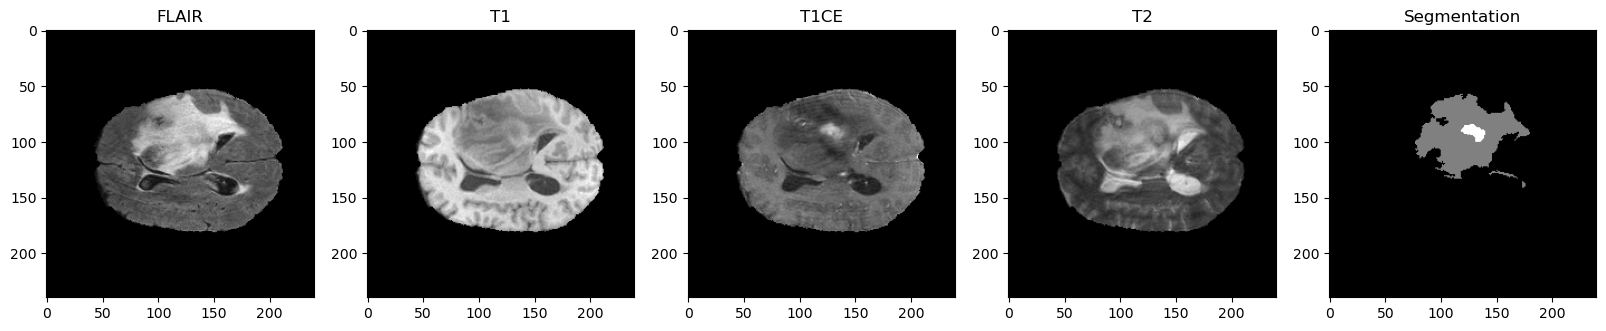

FLAIR Shape: (240, 240, 155)
T1 Shape: (240, 240, 155)
T1CE Shape: (240, 240, 155)
T2 Shape: (240, 240, 155)
Segmentation Shape: (240, 240, 155)
FLAIR Header: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern

In [36]:
# Plot all images in one patient

def plot_images(patient_id, path):
    patient_path = os.path.join(path, patient_id)
    flair = nib.load(os.path.join(patient_path, f"{patient_id}_flair.nii")).get_fdata()
    t1 = nib.load(os.path.join(patient_path, f"{patient_id}_t1.nii")).get_fdata()
    t1ce = nib.load(os.path.join(patient_path, f"{patient_id}_t1ce.nii")).get_fdata()
    t2 = nib.load(os.path.join(patient_path, f"{patient_id}_t2.nii")).get_fdata()
    seg = nib.load(os.path.join(patient_path, f"{patient_id}_seg.nii")).get_fdata()
    
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))
    ax[0].imshow(flair[..., 80], cmap="gray")
    ax[0].set_title("FLAIR")
    ax[1].imshow(t1[..., 80], cmap="gray")
    ax[1].set_title("T1")
    ax[2].imshow(t1ce[..., 80], cmap="gray")
    ax[2].set_title("T1CE")
    ax[3].imshow(t2[..., 80], cmap="gray")
    ax[3].set_title("T2")
    ax[4].imshow(seg[..., 80], cmap="gray")
    ax[4].set_title("Segmentation")
    plt.show()

    # print metadata
    print(f"FLAIR Shape: {flair.shape}")
    print(f"T1 Shape: {t1.shape}")
    print(f"T1CE Shape: {t1ce.shape}")
    print(f"T2 Shape: {t2.shape}")
    print(f"Segmentation Shape: {seg.shape}")

    # print header
    print(f"FLAIR Header: {nib.load(os.path.join(patient_path, f'{patient_id}_flair.nii')).header}")
    print(f"T1 Header: {nib.load(os.path.join(patient_path, f'{patient_id}_t1.nii')).header}")
    print(f"T1CE Header: {nib.load(os.path.join(patient_path, f'{patient_id}_t1ce.nii')).header}")
    print(f"T2 Header: {nib.load(os.path.join(patient_path, f'{patient_id}_t2.nii')).header}")
    print(f"Segmentation Header: {nib.load(os.path.join(patient_path, f'{patient_id}_seg.nii')).header}")

plot_images("BraTS20_Training_001", path_train)


In [ ]:
# Set up the radiomics feature extractor
params = {
    'binWidth': 25,
    'resampledPixelSpacing': [1, 1, 1],
    'interpolator': 'sitkBSpline',
    'featureClass': ['shape', 'firstorder', 'glcm', 'glrlm', 'ngtdm']  # Features to extract
}
extractor = featureextractor.RadiomicsFeatureExtractor(**params)

# Directory with BraTS data
data_dir = "./BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Function to process a single case and extract features
def extract_features(case_dir, output_csv):
    features_list = []

    for root, _, files in os.walk(case_dir):
        # Check if segmentation file exists in this directory
        seg_files = [f for f in files if f.endswith("seg.nii")]
        if not seg_files:
            continue  # Skip if no segmentation file

        # Extract case name from the segmentation file
        for seg_file in seg_files:
            case_name = "_".join(seg_file.split("_")[:3])  # Extract case name prefix
            seg_file_path = os.path.join(root, seg_file)

            # Find all modality files
            modalities = {}
            for modality in ['t1', 't1ce', 't2', 'flair']:
                modality_file = f"{case_name}_{modality}.nii"
                modality_path = os.path.join(root, modality_file)
                if os.path.exists(modality_path):
                    modalities[modality] = modality_path

            # Verify all required modalities are present
            if len(modalities) != 4:
                print(f"Skipping {case_name} due to missing modalities")
                continue

            # Load segmentation mask
            segmentation = sitk.ReadImage(seg_file_path)

            # Extract features for each modality
            for modality, img_path in modalities.items():
                print(f"Extracting features for {case_name} - {modality}")
                image = sitk.ReadImage(img_path)

                try:
                    features = extractor.execute(image, segmentation)
                    features_dict = {'case': case_name, 'modality': modality}
                    features_dict.update({k: v for k, v in features.items() if k.startswith("original")})
                    features_list.append(features_dict)
                except Exception as e:
                    print(f"Failed to extract features for {case_name} - {modality}: {e}")

    # Convert to DataFrame and save to CSV
    df = pd.DataFrame(features_list)
    df.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")

# Run the function for all cases
output_csv = "radiomics_features_training.csv"
extract_features(data_dir, output_csv)


Extracting features for BraTS20_Training_082 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_082 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_082 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_082 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_244 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_244 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_244 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_244 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_076 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_076 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_076 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_076 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_049 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_049 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_049 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_049 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_071 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_071 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_071 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_071 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_243 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_243 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_243 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_243 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_085 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_085 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_085 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_085 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_288 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_288 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_288 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_288 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_047 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_047 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_047 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_047 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_275 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_275 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_275 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_275 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_281 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_281 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_281 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_281 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_078 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_078 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_078 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_078 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_286 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_286 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_286 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_286 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_272 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_272 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_272 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_272 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_040 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_040 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_040 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_040 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_219 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_219 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_219 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_219 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_014 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_014 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_014 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_014 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_226 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_226 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_226 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_226 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_221 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_221 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_221 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_221 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_013 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_013 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_013 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_013 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_228 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_228 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_228 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_228 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_217 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_217 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_217 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_217 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_025 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_025 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_025 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_025 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_022 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_022 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_022 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_022 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_210 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_210 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_210 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_210 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_041 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_041 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_041 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_041 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_273 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_273 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_273 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_273 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_287 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_287 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_287 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_287 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_280 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_280 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_280 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_280 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_274 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_274 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_274 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_274 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_046 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_046 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_046 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_046 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_079 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_079 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_079 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_079 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_084 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_084 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_084 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_084 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_242 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_242 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_242 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_242 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_070 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_070 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_070 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_070 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_289 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_289 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_289 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_289 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_077 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_077 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_077 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_077 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_245 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_245 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_245 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_245 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_083 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_083 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_083 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_083 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_048 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_048 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_048 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_048 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_211 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_211 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_211 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_211 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_023 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_023 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_023 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_023 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_229 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_229 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_229 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_229 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_024 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_024 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_024 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_024 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_216 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_216 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_216 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_216 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_012 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_012 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_012 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_012 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_220 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_220 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_220 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_220 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_218 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_218 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_218 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_218 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_227 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_227 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_227 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_227 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_015 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_015 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_015 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_015 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_193 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_193 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_193 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_193 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_167 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_167 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_167 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_167 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_158 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_158 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_158 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_158 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_160 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_160 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_160 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_160 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_352 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_352 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_352 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_352 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_194 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_194 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_194 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_194 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_156 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_156 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_156 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_156 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_364 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_364 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_364 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_364 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_169 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_169 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_169 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_169 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_363 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_363 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_363 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_363 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_151 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_151 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_151 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_151 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_308 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_308 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_308 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_308 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_105 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_105 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_105 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_105 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_337 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_337 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_337 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_337 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_330 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_330 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_330 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_330 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_102 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_102 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_102 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_102 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_339 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_339 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_339 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_339 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_306 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_306 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_306 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_306 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_134 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_134 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_134 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_134 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_133 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_133 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_133 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_133 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_301 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_301 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_301 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_301 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_150 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_150 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_150 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_150 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_362 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_362 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_362 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_362 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_365 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_365 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_365 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_365 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_157 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_157 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_157 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_157 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_168 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_168 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_168 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_168 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_195 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_195 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_195 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_195 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_353 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_353 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_353 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_353 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_161 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_161 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_161 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_161 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_166 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_166 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_166 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_166 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_354 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_354 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_354 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_354 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_192 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_192 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_192 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_192 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_159 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_159 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_159 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_159 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_300 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_300 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_300 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_300 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_132 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_132 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_132 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_132 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_338 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_338 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_338 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_338 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_135 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_135 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_135 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_135 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_307 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_307 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_307 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_307 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_103 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_103 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_103 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_103 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_331 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_331 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_331 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_331 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_309 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_309 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_309 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_309 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_336 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_336 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_336 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_336 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_104 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_104 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_104 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_104 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_126 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_126 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_126 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_126 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_314 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_314 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_314 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_314 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_119 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_119 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_119 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_119 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_313 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_313 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_313 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_313 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_121 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_121 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_121 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_121 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_325 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_325 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_325 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_325 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_117 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_117 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_117 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_117 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_128 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_128 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_128 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_128 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_110 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_110 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_110 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_110 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_322 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_322 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_322 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_322 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_349 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_349 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_349 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_349 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_144 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_144 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_144 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_144 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_188 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_188 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_188 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_188 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_143 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_143 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_143 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_143 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_181 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_181 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_181 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_181 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_175 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_175 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_175 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_175 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_347 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_347 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_347 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_347 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_340 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_340 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_340 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_340 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_172 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_172 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_172 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_172 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_186 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_186 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_186 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_186 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_323 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_323 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_323 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_323 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_111 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_111 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_111 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_111 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_116 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_116 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_116 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_116 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_324 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_324 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_324 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_324 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_129 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_129 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_129 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_129 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_120 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_120 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_120 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_120 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_312 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_312 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_312 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_312 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_315 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_315 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_315 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_315 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_127 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_127 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_127 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_127 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_118 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_118 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_118 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_118 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_187 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_187 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_187 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_187 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_173 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_173 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_173 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_173 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_341 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_341 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_341 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_341 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_346 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_346 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_346 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_346 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_174 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_174 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_174 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_174 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_180 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_180 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_180 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_180 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_189 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_189 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_189 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_189 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_142 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_142 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_142 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_142 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_348 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_348 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_348 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_348 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_145 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_145 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_145 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_145 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_037 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_037 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_037 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_037 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_205 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_205 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_205 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_205 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_008 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_008 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_008 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_008 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_202 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_202 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_202 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_202 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_030 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_030 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_030 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_030 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_234 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_234 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_234 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_234 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_006 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_006 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_006 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_006 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_039 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_039 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_039 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_039 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_001 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_001 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_001 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_001 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_233 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_233 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_233 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_233 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_258 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_258 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_258 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_258 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_267 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_267 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_267 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_267 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_055 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_055 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_055 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_055 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_293 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_293 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_293 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_293 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_099 - t1
Failed to extract features for BraTS20_Training_099 - t1: Label (1) not present in mask. Choose from [2 4]
Extracting features for BraTS20_Training_099 - t1ce
Failed to extract features for BraTS20_Training_099 - t1ce: Label (1) not present in mask. Choose from [2 4]
Extracting features for BraTS20_Training_099 - t2
Failed to extract features for BraTS20_Training_099 - t2: Label (1) not present in mask. Choose from [2 4]
Extracting features for BraTS20_Training_099 - flair
Failed to extract features for BraTS20_Training_099 - flair: Label (1) not present in mask. Choose from [2 4]
Extracting features for BraTS20_Training_294 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_294 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_294 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_294 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_052 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_052 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_052 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_052 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_260 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_260 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_260 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_260 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_269 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_269 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_269 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_269 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_090 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_090 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_090 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_090 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_064 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_064 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_064 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_064 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_256 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_256 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_256 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_256 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_251 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_251 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_251 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_251 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_063 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_063 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_063 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_063 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_097 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_097 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_097 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_097 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_232 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_232 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_232 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_232 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_007 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_007 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_007 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_007 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_235 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_235 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_235 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_235 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_038 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_038 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_038 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_038 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_031 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_031 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_031 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_031 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_203 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_203 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_203 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_203 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_204 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_204 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_204 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_204 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_036 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_036 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_036 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_036 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_009 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_009 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_009 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_009 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_096 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_096 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_096 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_096 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_062 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_062 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_062 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_062 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_250 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_250 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_250 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_250 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_268 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_268 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_268 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_268 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_257 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_257 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_257 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_257 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_065 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_065 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_065 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_065 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_091 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_091 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_091 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_091 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_098 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_098 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_098 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_098 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_261 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_261 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_261 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_261 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_053 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_053 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_053 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_053 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_295 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_295 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_295 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_295 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_259 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_259 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_259 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_259 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_292 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_292 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_292 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_292 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_054 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_054 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_054 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_054 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_266 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_266 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_266 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_266 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_010 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_010 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_010 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_010 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_222 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_222 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_222 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_222 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_028 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_028 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_028 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_028 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_225 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_225 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_225 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_225 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_017 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_017 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_017 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_017 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_213 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_213 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_213 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_213 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_021 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_021 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_021 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_021 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_019 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_019 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_019 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_019 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_026 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_026 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_026 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_026 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_214 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_214 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_214 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_214 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_240 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_240 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_240 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_240 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_072 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_072 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_072 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_072 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_086 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_086 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_086 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_086 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_081 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_081 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_081 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_081 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_075 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_075 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_075 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_075 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_247 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_247 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_247 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_247 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_278 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_278 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_278 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_278 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_285 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_285 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_285 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_285 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_043 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_043 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_043 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_043 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_271 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_271 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_271 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_271 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_088 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_088 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_088 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_088 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_276 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_276 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_276 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_276 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_044 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_044 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_044 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_044 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_282 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_282 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_282 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_282 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_249 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_249 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_249 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_249 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_018 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_018 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_018 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_018 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_215 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_215 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_215 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_215 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_027 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_027 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_027 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_027 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_020 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_020 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_020 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_020 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_212 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_212 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_212 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_212 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_029 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_029 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_029 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_029 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_016 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_016 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_016 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_016 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_224 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_224 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_224 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_224 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_223 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_223 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_223 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_223 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_011 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_011 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_011 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_011 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_283 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_283 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_283 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_283 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_045 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_045 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_045 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_045 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_277 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_277 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_277 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_277 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_248 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_248 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_248 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_248 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_270 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_270 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_270 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_270 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_042 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_042 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_042 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_042 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_284 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_284 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_284 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_284 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_089 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_089 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_089 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_089 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_246 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_246 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_246 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_246 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_074 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_074 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_074 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_074 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_080 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_080 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_080 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_080 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_279 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_279 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_279 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_279 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_087 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_087 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_087 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_087 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_073 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_073 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_073 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_073 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_241 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_241 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_241 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_241 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_101 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_101 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_101 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_101 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_333 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_333 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_333 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_333 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_139 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_139 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_139 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_139 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_334 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_334 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_334 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_334 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_106 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_106 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_106 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_106 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_302 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_302 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_302 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_302 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_130 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_130 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_130 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_130 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_108 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_108 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_108 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_108 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_137 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_137 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_137 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_137 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_305 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_305 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_305 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_305 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_351 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_351 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_351 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_351 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_163 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_163 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_163 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_163 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_197 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_197 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_197 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_197 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_190 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_190 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_190 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_190 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_164 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_164 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_164 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_164 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_356 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_356 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_356 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_356 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_369 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_369 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_369 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_369 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_152 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_152 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_152 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_152 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_360 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_360 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_360 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_360 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_199 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_199 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_199 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_199 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_367 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_367 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_367 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_367 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_155 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_155 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_155 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_155 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_358 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_358 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_358 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_358 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_109 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_109 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_109 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_109 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_304 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_304 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_304 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_304 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_136 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_136 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_136 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_136 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_131 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_131 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_131 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_131 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_303 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_303 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_303 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_303 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_138 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_138 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_138 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_138 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_107 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_107 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_107 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_107 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_335 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_335 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_335 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_335 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_332 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_332 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_332 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_332 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_100 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_100 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_100 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_100 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_154 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_154 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_154 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_154 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_366 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_366 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_366 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_366 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_359 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_359 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_359 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_359 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_361 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_361 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_361 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_361 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_153 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_153 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_153 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_153 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_198 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_198 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_198 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_198 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_357 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_357 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_357 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_357 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_165 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_165 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_165 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_165 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_191 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_191 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_191 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_191 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_368 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_368 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_368 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_368 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_196 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_196 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_196 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_196 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_162 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_162 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_162 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_162 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_350 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_350 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_350 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_350 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_140 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_140 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_140 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_140 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_178 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_178 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_178 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_178 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_147 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_147 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_147 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_147 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_171 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_171 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_171 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_171 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_343 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_343 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_343 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_343 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_185 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_185 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_185 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_185 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_149 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_149 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_149 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_149 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_182 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_182 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_182 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_182 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_344 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_344 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_344 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_344 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_176 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_176 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_176 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_176 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_122 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_122 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_122 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_122 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_310 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_310 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_310 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_310 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_317 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_317 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_317 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_317 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_125 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_125 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_125 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_125 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_328 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_328 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_328 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_328 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_321 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_321 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_321 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_321 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_113 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_113 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_113 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_113 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_114 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_114 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_114 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_114 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_326 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_326 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_326 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_326 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_319 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_319 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_319 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_319 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_148 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_148 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_148 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_148 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_177 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_177 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_177 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_177 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_345 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_345 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_345 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_345 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_183 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_183 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_183 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_183 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_184 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_184 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_184 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_184 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_342 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_342 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_342 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_342 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_170 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_170 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_170 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_170 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_179 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_179 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_179 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_179 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_146 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_146 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_146 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_146 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_141 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_141 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_141 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_141 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_327 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_327 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_327 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_327 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_115 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_115 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_115 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_115 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_318 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_318 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_318 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_318 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_112 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_112 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_112 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_112 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_320 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_320 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_320 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_320 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_124 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_124 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_124 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_124 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_316 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_316 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_316 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_316 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_329 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_329 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_329 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_329 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_311 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_311 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_311 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_311 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_123 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_123 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_123 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_123 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_297 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_297 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_297 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_297 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_263 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_263 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_263 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_263 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_051 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_051 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_051 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_051 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_069 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_069 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_069 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_069 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_056 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_056 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_056 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_056 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_264 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_264 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_264 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_264 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_290 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_290 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_290 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_290 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_299 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_299 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_299 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_299 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_060 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_060 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_060 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_060 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_252 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_252 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_252 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_252 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_094 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_094 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_094 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_094 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_058 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_058 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_058 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_058 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_093 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_093 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_093 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_093 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_255 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_255 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_255 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_255 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_067 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_067 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_067 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_067 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_033 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_033 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_033 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_033 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_201 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_201 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_201 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_201 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_206 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_206 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_206 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_206 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_034 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_034 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_034 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_034 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_239 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_239 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_239 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_239 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_230 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_230 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_230 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_230 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_002 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_002 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_002 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_002 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_005 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_005 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_005 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_005 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_237 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_237 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_237 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_237 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_208 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_208 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_208 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_208 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_059 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_059 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_059 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_059 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_066 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_066 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_066 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_066 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_254 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_254 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_254 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_254 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_092 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_092 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_092 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_092 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_298 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_298 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_298 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_298 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_095 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_095 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_095 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_095 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_253 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_253 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_253 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_253 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_061 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_061 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_061 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_061 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_068 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_068 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_068 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_068 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_291 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_291 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_291 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_291 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_265 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_265 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_265 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_265 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_057 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_057 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_057 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_057 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_050 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_050 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_050 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_050 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_262 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_262 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_262 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_262 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_296 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_296 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_296 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_296 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_236 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_236 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_236 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_236 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_004 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_004 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_004 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_004 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_209 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_209 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_209 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_209 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_003 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_003 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_003 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_003 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_231 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_231 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_231 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_231 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_035 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_035 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_035 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_035 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_207 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_207 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_207 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_207 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_238 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_238 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_238 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_238 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_200 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_200 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_200 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_200 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_032 - t1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_032 - t1ce


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_032 - t2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Extracting features for BraTS20_Training_032 - flair


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Features saved to radiomics_features_training.csv


In [30]:
feat_train = pd.read_csv("radiomics_features_training.csv")
feat_train.head()

,case,modality,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,BraTS20_Training_082,t1,0.615924,0.558094,13.056671,23.395129,19.416488,26.019224,25.317978,26.381812,...,17.728821,0.034186,4.577973,0.073720,5594.245790,3.772769,0.004038,19.403883,0.012255,0.145263
1,BraTS20_Training_082,t1ce,0.615924,0.558094,13.056671,23.395129,19.416488,26.019224,25.317978,26.381812,...,57.907309,0.025878,5.397345,0.279122,226.364135,2.069651,0.004579,171.683748,0.079231,0.489439
2,BraTS20_Training_082,t2,0.615924,0.558094,13.056671,23.395129,19.416488,26.019224,25.317978,26.381812,...,20.205082,0.068509,4.914484,0.093979,3937.882893,3.526301,0.004393,24.992246,0.016806,0.190565
3,BraTS20_Training_082,flair,0.615924,0.558094,13.056671,23.395129,19.416488,26.019224,25.317978,26.381812,...,46.333260,0.011570,5.316090,0.137873,1342.442082,1.222249,0.004867,79.792367,0.021403,0.483111
4,BraTS20_Training_244,t1,0.739970,0.638121,33.263382,52.127075,55.605755,62.177166,61.188234,67.238382,...,70.928456,0.016404,6.640294,0.031081,100764.505286,7.443644,0.000508,262.315113,0.012017,0.353904
